In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from la_forge.core import Core

import defiant
from defiant import OptimalStatistic
from defiant import utils, orf_functions, null_distribution as nulls
from defiant import plotting as defplot

from defiant.extra import mdc1_utils


print("Using defiant from:",defiant.__file__)

Using defiant from: /Users/gersbaka/Documents/Projects/Software_dev/defiant/defiant/__init__.py


In [2]:
# Returns both the list of pulsars and the injected parameters
psrs,inj_params = mdc1_utils.get_MDC1_psrs() 
# Create the PTA based on the pulsars loaded
pta = mdc1_utils.create_MDC1_PTA(psrs, gwb_components=10, gwb_name='gw') 


# For future plots, we will want the injected spectrum too
fgw = utils.get_pta_frequencies(pta, gwb_name='gw') # You can also get this with os_obj.freqs
inj_spectrum = utils.powerlaw(fgw, inj_params['gw_log10_A'], inj_params['gw_gamma'])

Loading MDC1 psrs:   0%|          | 0/36 [00:00<?, ?it/s]

[tempo2Util.C:396] Warning: [TIM1] Please place MODE flags in the parameter file 
[tempo2Util.C:401] Warning: [DUP1] duplicated warnings have been suppressed.


In [3]:
to_sample = False

if to_sample:
    from enterprise_extensions.sampler import setup_sampler

    chain_loc = 'MDC1_FG_CURN_samples/'

    # Use enterprise_extensions setup_sampler to speed up the process!
    sampler = setup_sampler(pta, chain_loc, resume=True, human='KAG')

    x0 = np.hstack([p.sample() for p in pta.params]) # Get an initial sample

    sampler.sample(x0, Niter=int(1e6)) # Run a million samples

    lfcore = Core(chaindir=chain_loc)

    lfcore.save('MDC1_FG_CURN_samples.core')
    
else:
    # Load in the core object
    lfcore = Core(corepath='./MDC1_FG_CURN_samples.core')

In [5]:
# Since we created our PTA object with 'gw' as the name, make sure to set that!
OS_obj = OptimalStatistic(psrs, pta=pta, gwb_name='gw', core=lfcore, orfs=['hd'])

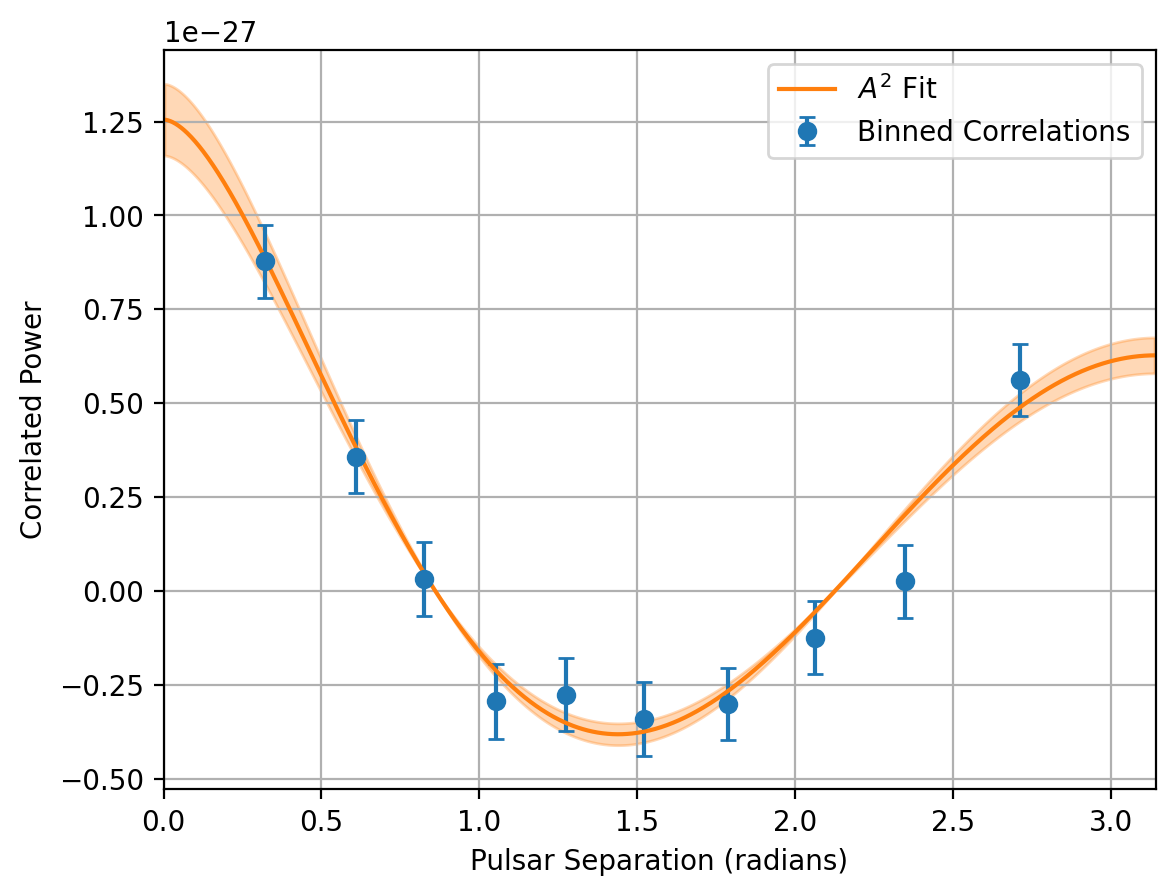

In [8]:
OS_obj.set_orf(['hd'])
xi,rho,sig,C,A2,A2s,idx = OS_obj.compute_OS(params=inj_params)

defplot.create_correlation_plot(xi,rho,sig,C,A2,A2s,bins=10);

## Phase shifting

### single-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


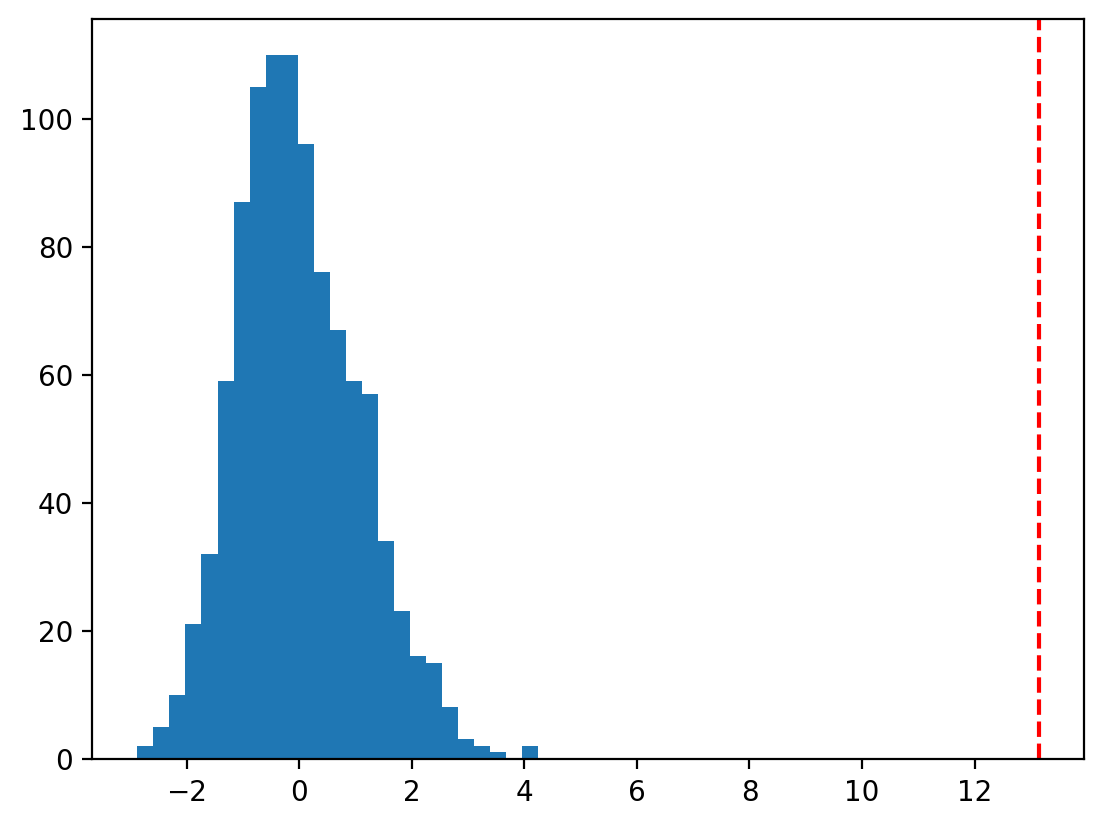

In [11]:
from defiant.null_distribution import phase_shift_OS

OS_obj.set_orf(['hd'])
p,snr,n_dist = phase_shift_OS(OS_obj,inj_params,n_shifts=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

### multi-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


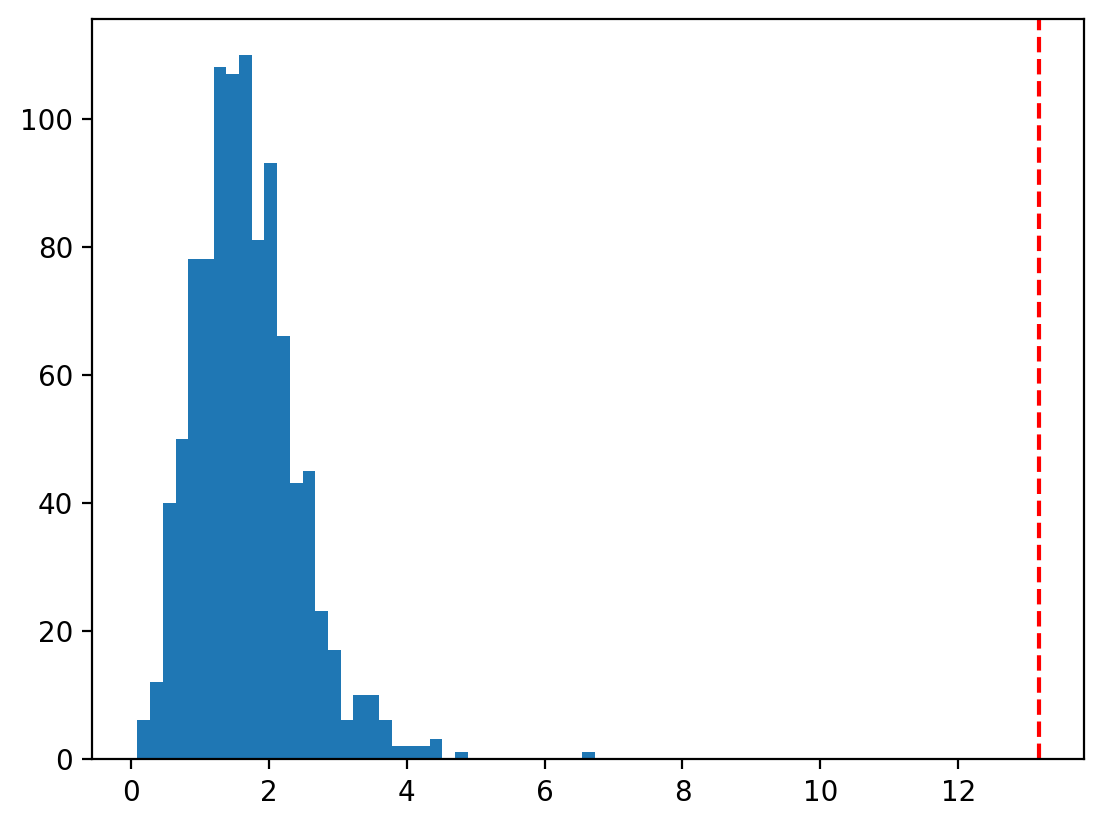

In [12]:
OS_obj.set_orf(['hd','dp','mp'])
p,snr,n_dist = phase_shift_OS(OS_obj,inj_params,n_shifts=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

## Sky scrambling

### single-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


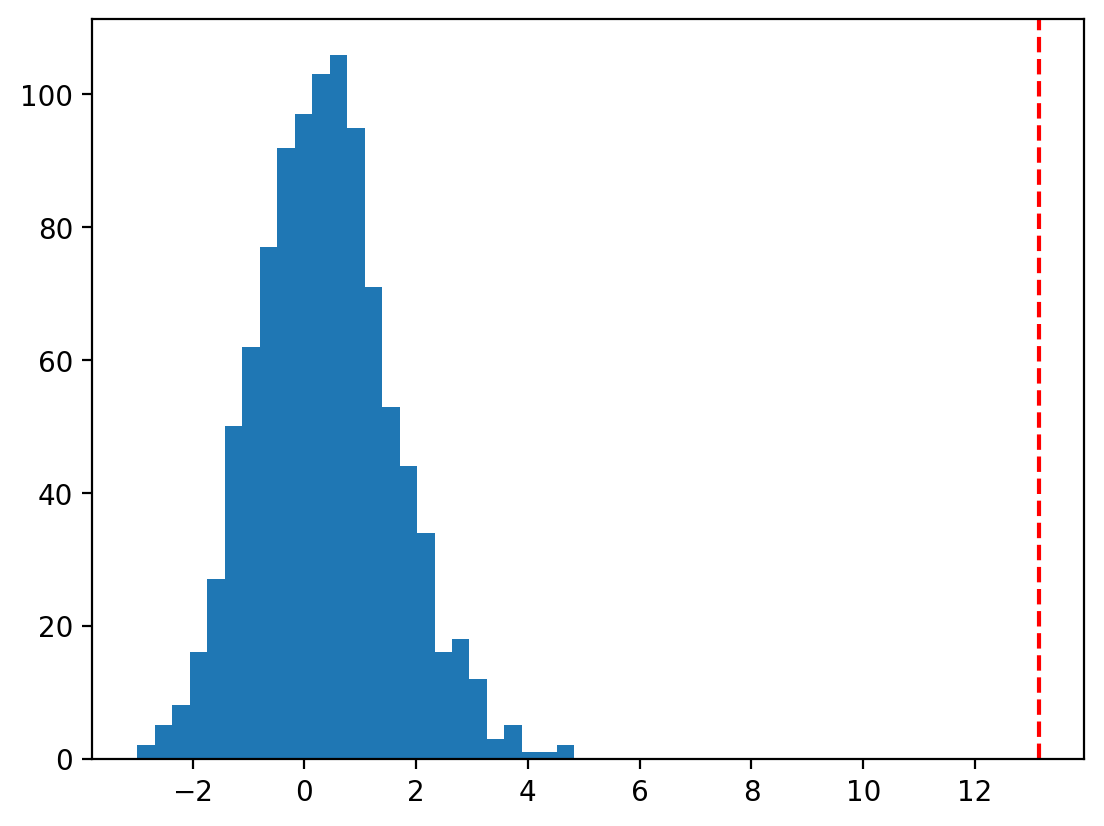

In [ ]:
from defiant.null_distribution import sky_scramble_OS

OS_obj.set_orf(['hd'])
p,snr,n_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

### Check if swapping positions is different than new positions

In [94]:
OS_obj.set_orf(['hd'])
p,snr,n_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=int(1e5),swap_pos=False)
_,_,swap_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=int(1e5),swap_pos=True)

shifts:   0%|          | 0/100000 [00:00<?, ?it/s]

shifts:   0%|          | 0/100000 [00:00<?, ?it/s]

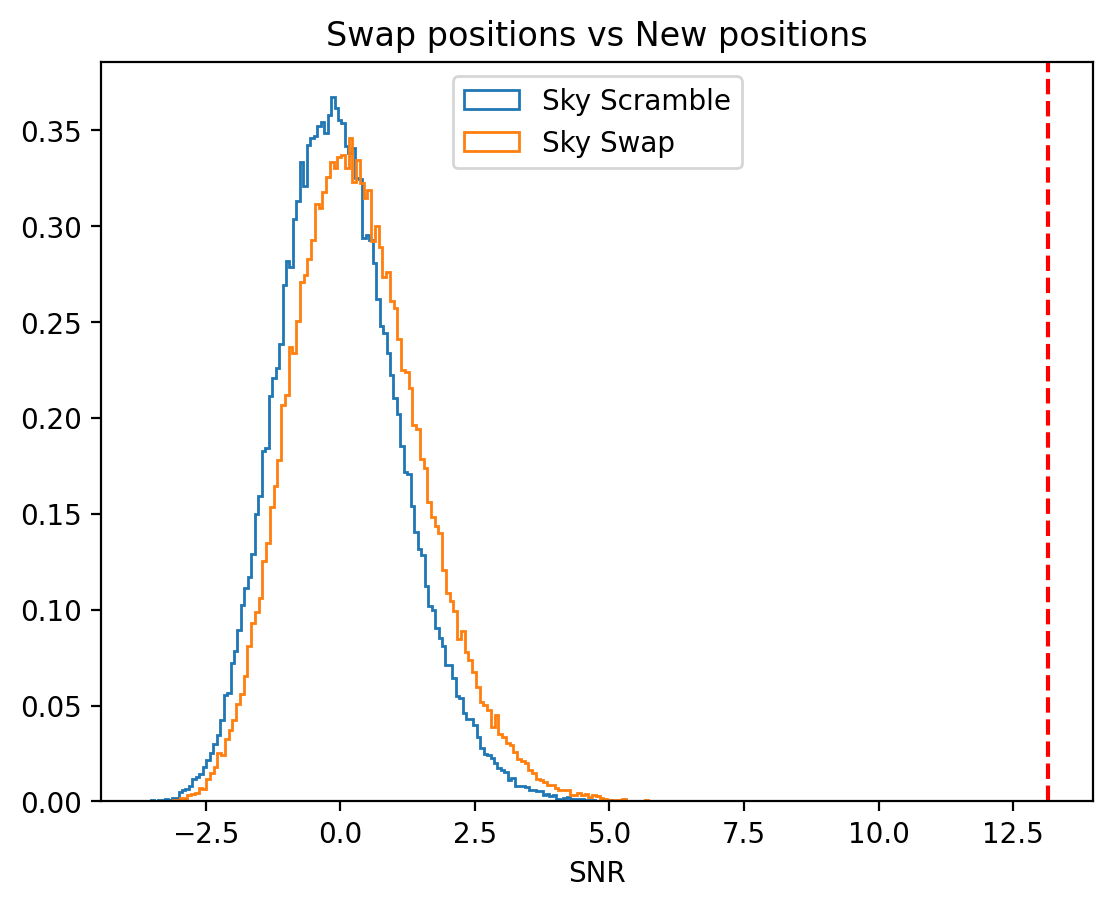

In [95]:
plt.hist(n_dist,bins='auto',histtype='step',label='Sky Scramble',density=True);
plt.hist(swap_dist,bins='auto',histtype='step',label='Sky Swap',density=True);
plt.axvline(snr, color='r', linestyle='--')
plt.legend()
plt.xlabel('SNR')
plt.title('Swap positions vs New positions')
plt.show()

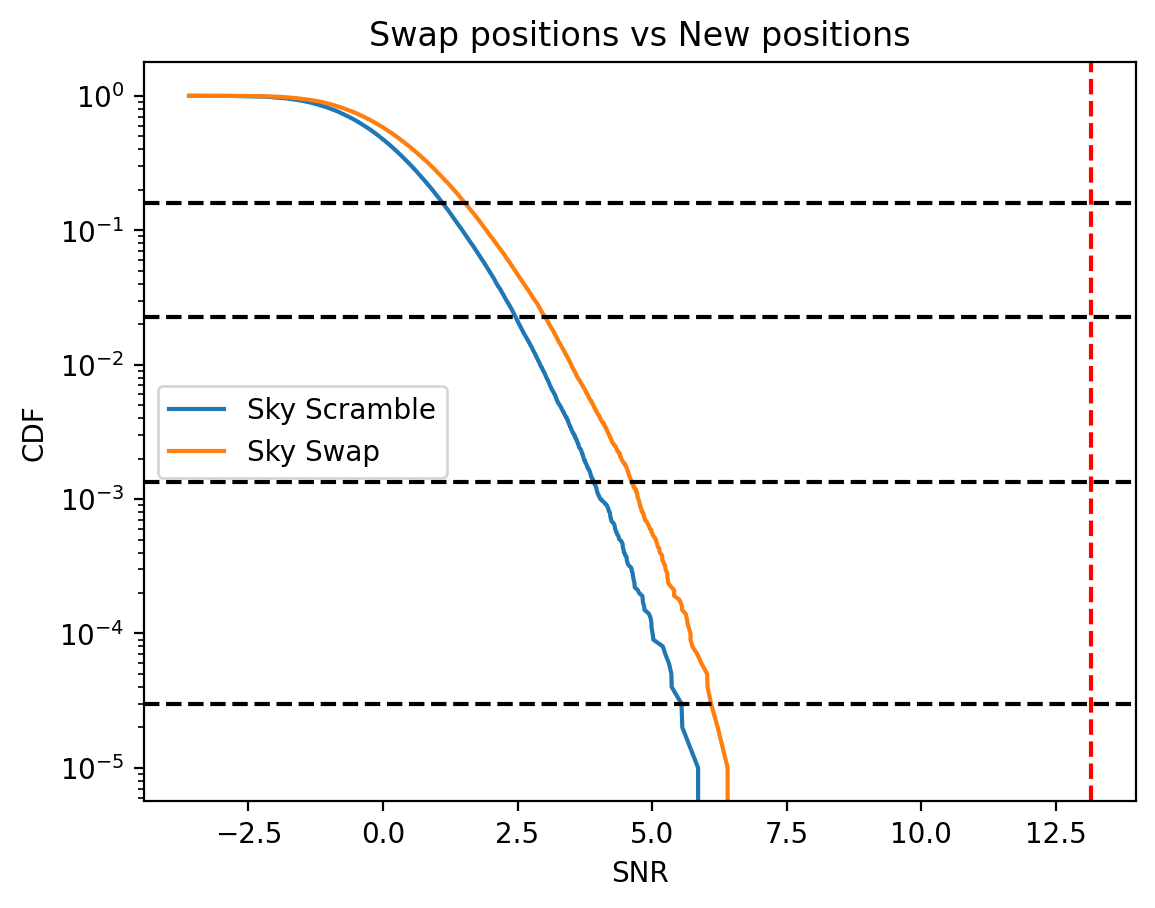

In [100]:
n_dist = np.sort(n_dist)
plt.plot(n_dist,1-np.linspace(0,1,len(n_dist)),label='Sky Scramble')
swap_dist = np.sort(swap_dist)
plt.plot(swap_dist,1-np.linspace(0,1,len(swap_dist)),label='Sky Swap')
plt.axvline(snr, color='r', linestyle='--')

plt.axhline(1-0.84134, color='k', linestyle='--')
plt.axhline(1-0.97725, color='k', linestyle='--')
plt.axhline(1-0.99865, color='k', linestyle='--')
plt.axhline(1-0.99997, color='k', linestyle='--')

plt.legend()
plt.xlabel('SNR')
plt.ylabel('CDF')
plt.title('Swap positions vs New positions')
plt.yscale('log')
plt.show()

### multi-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


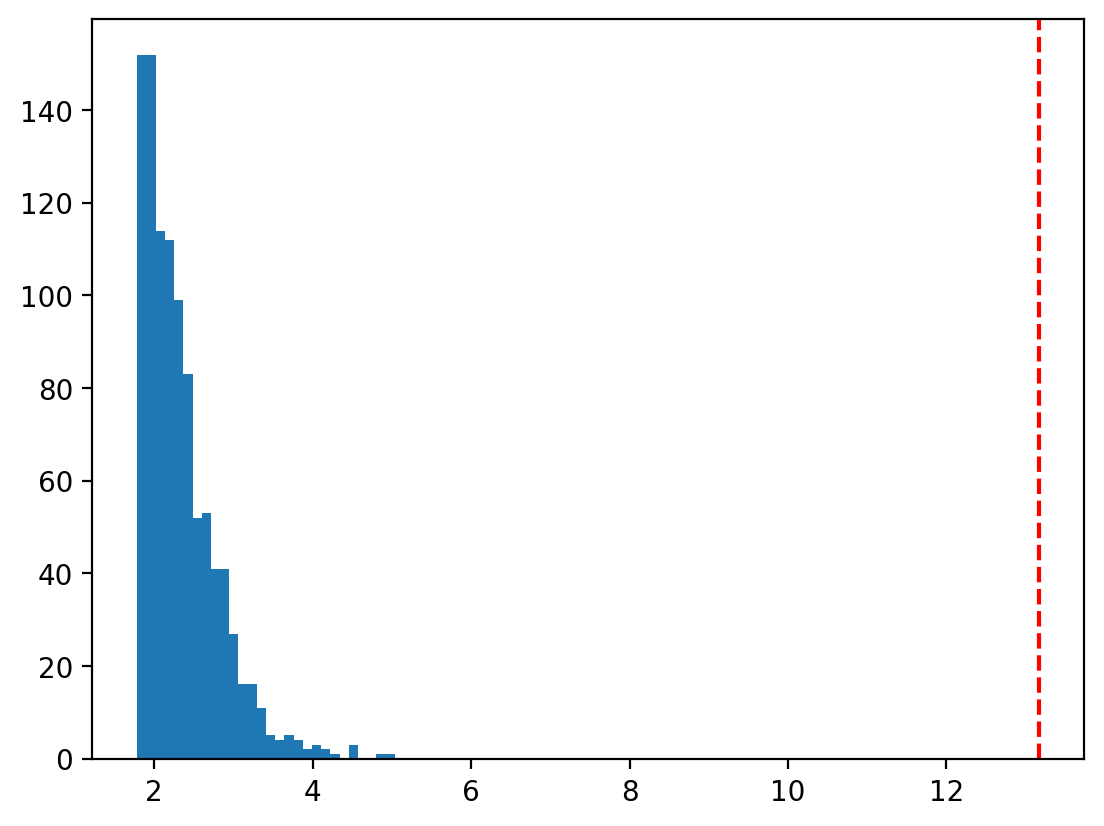

In [80]:
OS_obj.set_orf(['hd','dp','mp'])
p,snr,n_dist = sky_scramble_OS(OS_obj,inj_params,n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

## Super scrambles (phase shift + sky scramble)

### single-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


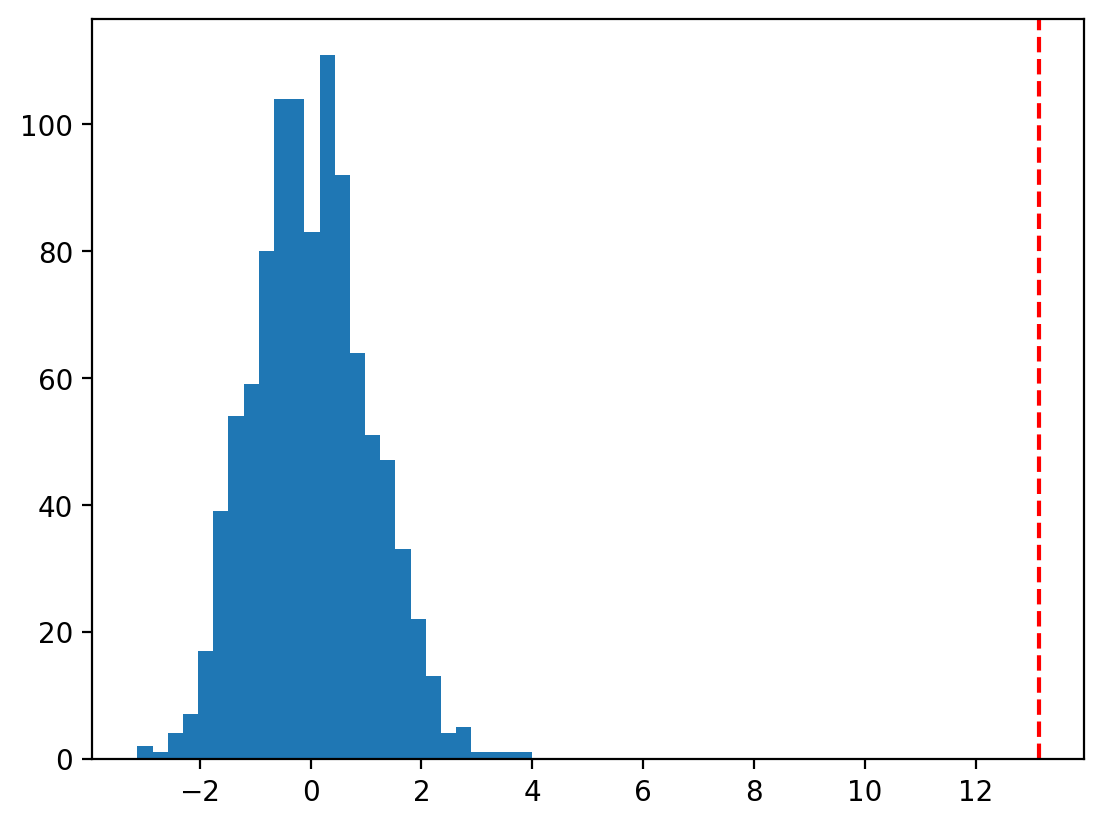

In [101]:
from defiant.null_distribution import super_scramble_OS

OS_obj.set_orf(['hd'])
p,snr,n_dist = super_scramble_OS(OS_obj, inj_params, n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)

### multi-component

shifts:   0%|          | 0/1000 [00:00<?, ?it/s]

P-value: 0.0


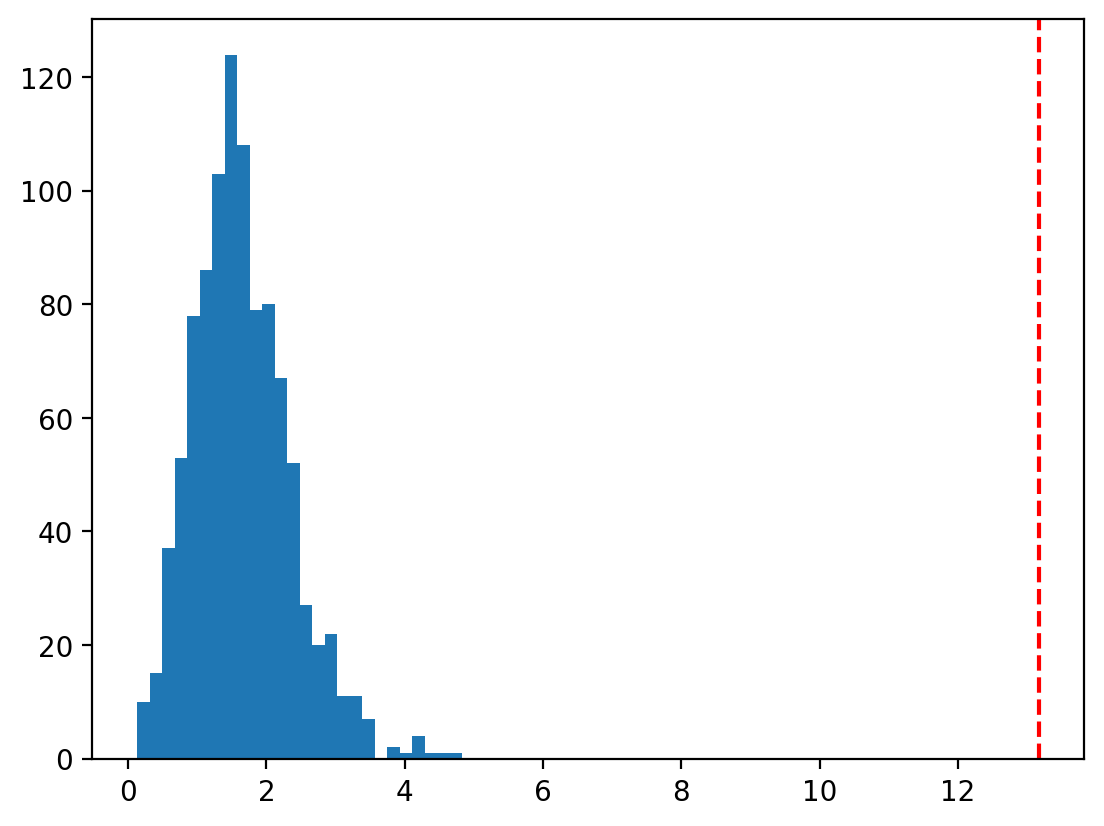

In [102]:
OS_obj.set_orf(['hd','dp','mp'])
p,snr,n_dist = super_scramble_OS(OS_obj, inj_params, n_scrambles=1000)

plt.hist(n_dist,bins='auto');
plt.axvline(snr, color='r', linestyle='--')
print('P-value:',p)